In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from glob import glob
import os
import random
import time
from collections import Counter
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
from blood_dataset import blood_cell_dataset

In [2]:
cwd = os.getcwd()
training_images = glob(f'{cwd}/Training/Images')
testing_images = glob(f'{cwd}/Testing/Images')

In [3]:
training_images[0]

'/Users/klynete/Desktop/Springboard/Complete-Blood-Cell-Count/Training/Images'

In [4]:
# Load the csv files
train_df = pd.read_csv("Training.csv")
test_df = pd.read_csv("Testing.csv")

## Faster R-CNN model

Faster R-CNN is a popular object detection model that uses a Region Proposal Network (RPN) to generate object proposals for the subsequent detection stage. The model consists of two stages: the first stage generates object proposals using the RPN, and the second stage classifies and refines the proposals. Faster R-CNN is an extension of the original Fast R-CNN model, which used selective search to generate object proposals. The RPN replaces the selective search module in the original Fast R-CNN model, making it faster and more accurate.

The backbone of the Faster R-CNN model is a convolutional neural network (CNN), which is used to extract features from the input image. The CNN acts as a feature extractor that takes an image as input and outputs a feature map. The feature map is then passed to the RPN to generate object proposals. The feature extractor needs to be a powerful network that can extract high-level features from the input image. The most commonly used backbones in Faster R-CNN are ResNet and VGGNet.

ResNet is a deep residual network that is widely used in computer vision tasks. The network consists of multiple residual blocks that allow for deeper network architectures without the problem of vanishing gradients. The feature map generated by the backbone network is passed to the RPN, which generates object proposals based on the features. The proposals are then passed to the second stage of the model, which classifies and refines the proposals.

The Fast R-CNN network takes the proposals generated by the RPN as input and performs object classification and bounding box regression. The network first extracts features from the proposed regions using a RoI pooling layer, which generates fixed-size feature maps for each proposal. The RoI pooling layer also preserves the spatial locations of the features within each proposal. The features are then fed into a set of fully connected layers to perform object classification and bounding box regression. The model is trained end-to-end using a multi-task loss function that combines the classification and regression losses for the object detection task.

### Visualize image with boundaries around cells

In [5]:
def plot_img(df, imgdir, image_name):
    
    fig, ax = plt.subplots(1, 2, figsize = (14, 14))
    ax = ax.flatten()
    
    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(imgdir, image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = image/255.0
    image2 = image
    
    ax[0].set_title('Original Image '+image_name)
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['cell_type']
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 3)
        font = cv2.FONT_ITALIC
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, (255,0,0), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


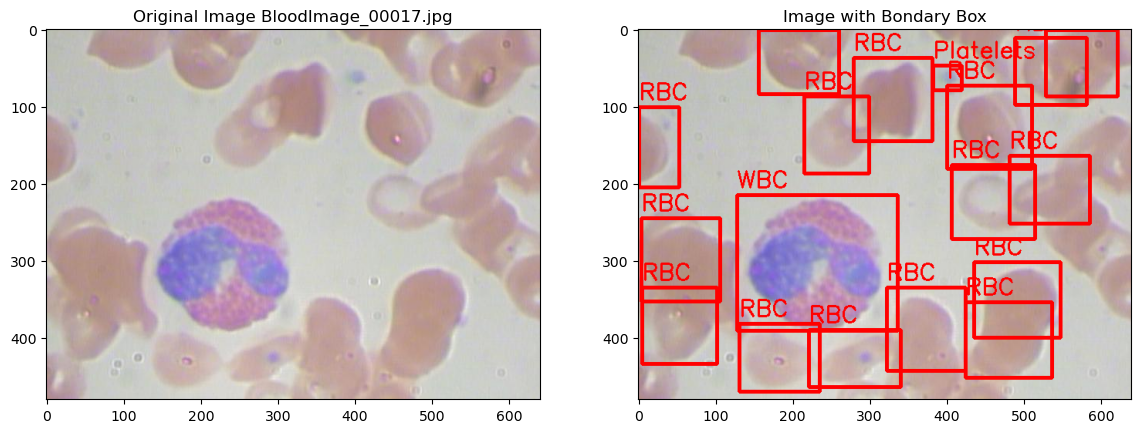

In [6]:
plot_img(train_df, training_images[0], "BloodImage_00017.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


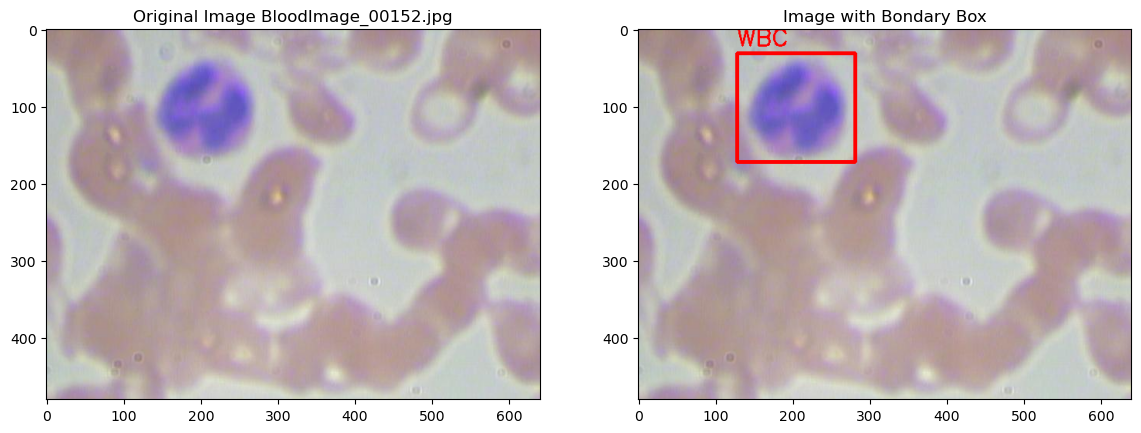

In [7]:
plot_img(train_df, training_images[0],"BloodImage_00152.jpg")

### Training and Test sets preparation

In [8]:
cell_types=train_df['cell_type'].unique()
# add background to classes types
classes = np.insert(cell_types, 0, "background", axis=0)
class_to_int = {classes[i] : i for i in range(len(classes))}
int_to_class = {i : classes[i] for i in range(len(classes))}
print(class_to_int, int_to_class)

{'background': 0, 'RBC': 1, 'WBC': 2, 'Platelets': 3} {0: 'background', 1: 'RBC', 2: 'WBC', 3: 'Platelets'}


In [9]:
# Using torchvision.transforms - without Augmentation
def get_transform():
    return transforms.Compose([transforms.ToTensor()])
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
#blood_cell_dataset is class for Dataset object 
#(saved separately as blood_dataset.py, it takes df and transform it in required format)
train_dataset=blood_cell_dataset(train_df, training_images[0], transforms = get_transform())
test_dataset=blood_cell_dataset(test_df, testing_images[0], mode = 'test',transforms = get_transform())

In [11]:
#check format of train_dataset elements
train_dataset[0]

(tensor([[[0.7137, 0.7098, 0.7098,  ..., 0.7529, 0.7451, 0.7490],
          [0.7137, 0.7098, 0.7098,  ..., 0.7529, 0.7451, 0.7490],
          [0.7137, 0.7098, 0.7098,  ..., 0.7529, 0.7451, 0.7490],
          ...,
          [0.7373, 0.7412, 0.7412,  ..., 0.7725, 0.7686, 0.7647],
          [0.7373, 0.7412, 0.7412,  ..., 0.7725, 0.7686, 0.7647],
          [0.7373, 0.7412, 0.7412,  ..., 0.7725, 0.7647, 0.7647]],
 
         [[0.7373, 0.7333, 0.7333,  ..., 0.7608, 0.7529, 0.7569],
          [0.7373, 0.7333, 0.7333,  ..., 0.7608, 0.7529, 0.7569],
          [0.7373, 0.7333, 0.7333,  ..., 0.7608, 0.7529, 0.7569],
          ...,
          [0.7647, 0.7686, 0.7686,  ..., 0.7922, 0.7882, 0.7843],
          [0.7647, 0.7686, 0.7686,  ..., 0.7922, 0.7882, 0.7843],
          [0.7647, 0.7686, 0.7686,  ..., 0.7922, 0.7843, 0.7843]],
 
         [[0.6824, 0.6784, 0.6784,  ..., 0.7412, 0.7333, 0.7373],
          [0.6824, 0.6784, 0.6784,  ..., 0.7412, 0.7333, 0.7373],
          [0.6824, 0.6784, 0.6784,  ...,

In [12]:
#Preparing data loaders
#batch size is 4 for each iteration of the training
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 0,
    collate_fn = collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size = 1,
    drop_last=False,
    shuffle = False,
    num_workers = 0,
    collate_fn = collate_fn
)

In [13]:
### Create / load model
#Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/Users/klynete/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/klynete/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

Device: cpu


In [15]:
#We will retrain the model to fine-tune all its parameters for our training dataset
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Retrain model on Train dataset images with boxes

In [72]:
'''
itr = 1
epochs=5
total_train_loss = []

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss = []
    
    #Retriving Mini-batch
    for images, targets, image_names in train_data_loader:
        
        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        #Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        #Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        if itr % 25 == 0:
            print(f"\n Iteration #{itr} loss: {out} \n")

        itr += 1
    
    #We won't use lr_scheduler in this case as we have only small number of epochs training
    #lr_scheduler.step()    
    
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")'''


 Iteration #25 loss: {'loss_classifier': tensor(0.4244, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4453, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0628, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0244, grad_fn=<DivBackward0>)} 


 Iteration #50 loss: {'loss_classifier': tensor(0.3622, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.5651, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0185, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0263, grad_fn=<DivBackward0>)} 


 Iteration #75 loss: {'loss_classifier': tensor(0.3217, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.5213, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0090, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0300, grad_fn=<DivBackward0>)} 

Epoch train loss is 1.1033
Time elapsed:  2831.795696735382

 Iteration #100 loss: {'loss_classifier': tensor(0.3098, grad_fn=<NllLossBa

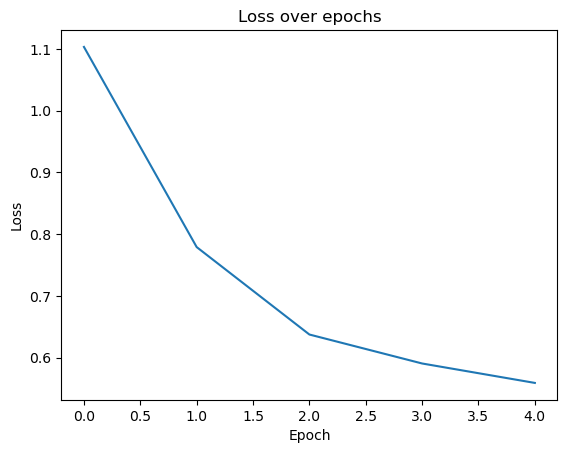

In [244]:
# Plot the loss values
plt.plot(total_train_loss)
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [16]:
#Save the model
#torch.save(model.state_dict(), 'model.pt')
#Load the model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Predict on Test dataset

In [17]:
#predict for test dataset
model.eval()
img_n_r=[]
predictions=[]
with torch.no_grad():
    for images, img_n in test_data_loader:

    #Forward ->
        images = list(image.to(device) for image in images)
        output = model(images)
        predictions=predictions+output
        img_n_r=img_n_r+list(img_n)

### Analyze predictions

In [18]:
#Function to filter out results by thresholdsn thresh_by_type={'Platelets': 0, 'RBC': 0, 'WBC': 0}
#thresh_prediction for each image prediction separtely by each class threshold
def thresh_prediction(prediction, thresh_by_type, nms_iou_threshold):
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"].cpu().numpy()
    
    # Convert labels to classes.
    labels = [int_to_class[l] for l in labels]
    
    # Remove any low-score predictions based on the threshold for each type of object.
    boxes_th = []
    scores_th = []
    labels_th = []
    for class_name in thresh_by_type:
        threshold = thresh_by_type[class_name]
        class_idx = [i for i, l in enumerate(labels) if l == class_name]
        if len(class_idx) == 0:
            continue
        want = scores[class_idx] > threshold
        boxes_th.extend(boxes[class_idx][want].cpu().numpy())
        scores_th.extend(scores[class_idx][want].cpu().numpy())
        labels_th.extend([class_name] * want.sum())
    
    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        boxes_th = torch.tensor(np.array(boxes_th))
        scores_th = torch.tensor(np.array(scores_th))
        keep = torchvision.ops.nms(boxes_th, scores_th, iou_threshold=nms_iou_threshold)
        boxes_th = boxes_th[keep].cpu().numpy()
        scores_th = scores_th[keep].cpu().numpy()
        labels_th = [labels_th[k] for k in keep]
    
    return (boxes_th, labels_th, scores_th)

In [19]:
#Function to filter out predictions for all images in test dataset and return dataframe
def filtered_predictions(predictions, img_n_r, thresh_by_type, nms_iou_threshold):
    res_nms=pd.DataFrame(columns = ["filename", "cell_type", "xmin", "ymin", "xmax", "ymax", "score"])
    for i,im in enumerate(img_n_r):
        b,l,s=thresh_prediction(predictions[i], thresh_by_type, nms_iou_threshold=nms_iou_threshold)
        for y in range(len(b)):
            #Bboxes, classname & image name
            xmin = b[y][0]
            ymin = b[y][1]
            xmax = b[y][2]
            ymax = b[y][3]
            cell_type = l[y]
            score=s[y]

            #Creating row for df
            row = {"filename" : im, "cell_type":cell_type, "xmin": xmin, "ymin":ymin, "xmax": xmax, "ymax": ymax, "score":score}

            #Appending to df
            res_nms = pd.concat([res_nms, pd.DataFrame([row])], ignore_index = True)
    return res_nms

In [20]:
thresh_by_type_d={'Platelets': 0.0, 'RBC': 0.0, 'WBC': 0.0}
res_all=filtered_predictions(predictions, img_n_r, thresh_by_type_d, nms_iou_threshold=None)

In [21]:
res_all.shape

(2126, 7)

#### Check original count of labels by cell_type in test_df

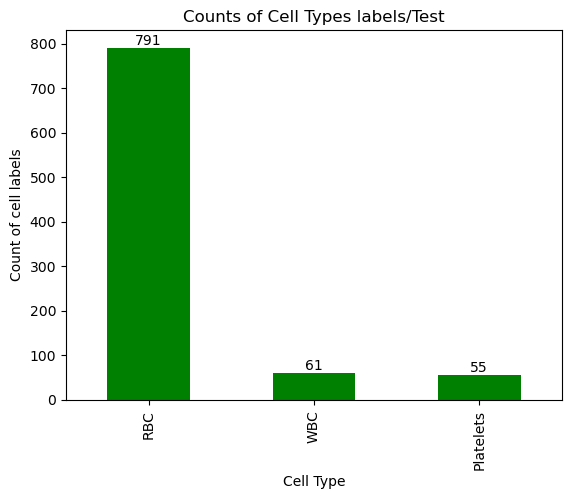

In [22]:
test_counts = test_df.groupby('cell_type')['filename'].count().sort_values(ascending=False)
ax = test_counts.plot(kind='bar', color='green')
plt.title('Counts of Cell Types labels/Test')
plt.xlabel('Cell Type')
plt.ylabel('Count of cell labels')

# Add annotations for each bar
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.annotate(str(y), (x, y), ha='center', va='bottom')

plt.show()

#### Plot distribution of scores for each class

In [23]:
#plot predictions boxes scores by cell_type
def plot_by_cell_type(df_scores,cell_type):
    # Filter dataframe by cell type
    df_cell = df_scores[df_scores['cell_type'] == cell_type]

    # Compute histogram and cumulative count
    hist, bins = np.histogram(df_cell['score'], bins=30)
    cum_count = np.cumsum(hist)

    # Compute total count and inverse cumulative count
    total_count = len(df_cell)
    inv_cum_count = total_count - cum_count

    # Plot histogram with inverse cumulative count
    fig, ax = plt.subplots()
    ax.hist(df_cell['score'], bins=30, alpha=0.5, label='Histogram')
    ax2 = ax.twinx()
    ax2.plot(bins[:-1], inv_cum_count, color='red', label='Inverse Cumulative Count')
    #show ground truth count of cell type
    ax2.axhline(y=test_counts[cell_type], color='black', linestyle='--', label=cell_type +' count = '+str(test_counts[cell_type]))
    ax2.set_ylabel('Inverse Cumulative Count')
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.legend()
    ax2.legend(loc='upper right')
    plt.title('Histogram with Inverse Cumulative Count for '+cell_type)
    plt.show()


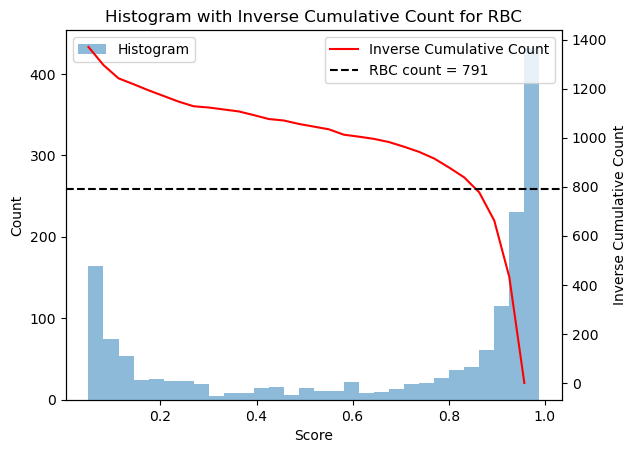

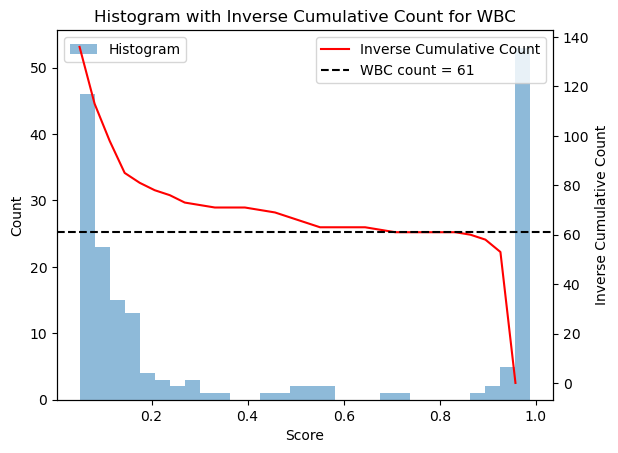

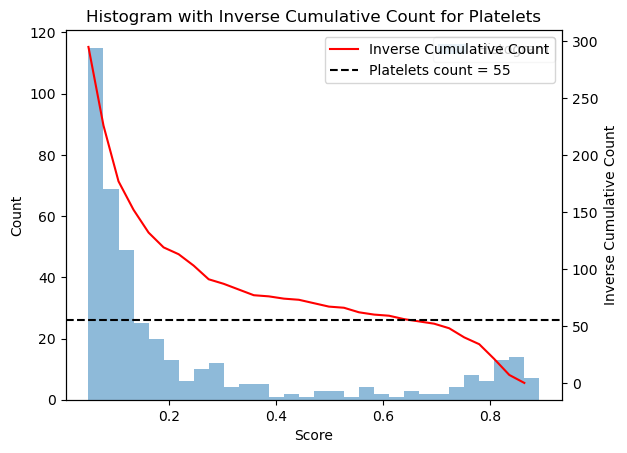

In [24]:
plot_by_cell_type(res_all,'RBC')
plot_by_cell_type(res_all,'WBC')
plot_by_cell_type(res_all,'Platelets')

As we can see our predictions contain much more labeled boxes for all 3 classes. We need to filter out predictions in order to obtain more accurate results. 
We can use next aproaches:
1. Set thresholds for scores to filter out boxes for each class:
    - For 'RBC' it can be in range of [0.5,0.7] - it will give around 1000 predicted boxes of this class 
    - For 'WBC' it can be in range of [0.7,0.8] - it will give around 61 predicted boxes of this class 
    - For 'Platelets' it can be in range of [0.4, 0.6] - it will give around 60 predicted boxes of this class
2. Use NMS approach to filtered boxes: NMS (Non-Maximum Suppression) is a technique used in object detection tasks to eliminate overlapping bounding boxes for the same object in an image. NMS_Threshold will be set to remove boxes with lower score if IoU is higher than NMS_Threshold


Let's visualize what unfiltered predictions look like:

In [25]:
def compare_img(df1, df2, imgdir, image_name):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
    
    bbox = df1[df1['filename'] == image_name]
    bbox_r = df2[df2['filename'] == image_name]
    
    img_path = os.path.join(imgdir, image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    image_with_boxes = image.copy()
    
    # Plot original image with boxes
    ax1.set_title(image_name+ ' with labeled boxes')
    for idx, row in bbox.iterrows():
        x1, y1, x2, y2 = row[['xmin', 'ymin', 'xmax', 'ymax']]
        label = row['cell_type']
        
        cv2.rectangle(image_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
        font = cv2.FONT_ITALIC
        cv2.putText(image_with_boxes, label, (int(x1), int(y1 - 10)), font, 1, (255, 0, 0), 2)
    ax1.imshow(image_with_boxes)
    
    # Plot image with predicted boxes
    image_with_pred_boxes = image.copy()
    
    ax2.set_title(image_name+ ' with predicted boxes')
    for idx, row in bbox_r.iterrows():
        x1, y1, x2, y2 = row[['xmin', 'ymin', 'xmax', 'ymax']]
        label = row['cell_type']
        
        cv2.rectangle(image_with_pred_boxes, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
        font = cv2.FONT_ITALIC
        cv2.putText(image_with_pred_boxes, label, (int(x1), int(y1 - 10)), font, 1, (255, 0, 0), 2)
    ax2.imshow(image_with_pred_boxes)
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


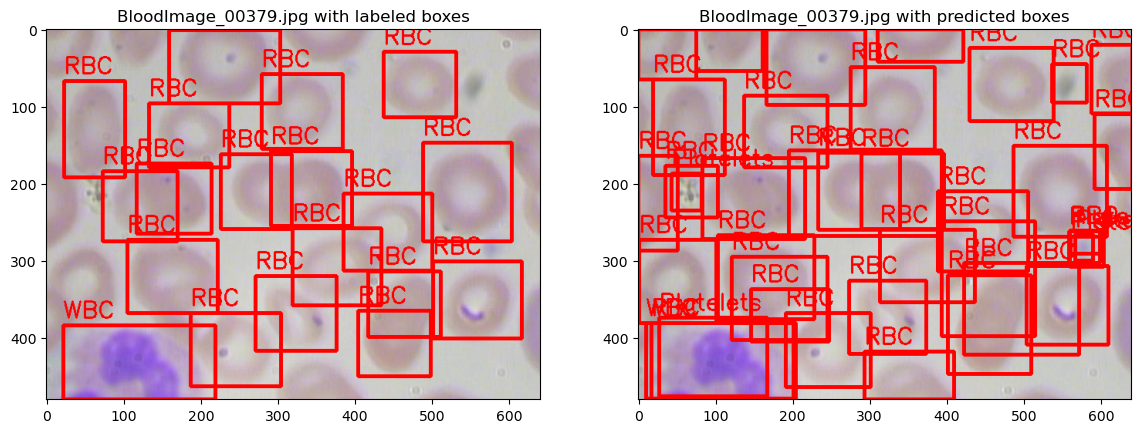

In [26]:
compare_img(test_df, res_all, testing_images[0], "BloodImage_00379.jpg")

As we can see model predicts different labeled boxes with different level of confidence (score) for the same image area. We need to set thresholds for scores and intersected boxes to maximize evaluation metric.

### Define mAP metric for object detection model

In computer vision, mAP is a popular evaluation metric used for object detection (i.e. localization and classification). Localization determines the location of an instance (bounding box coordinates) and classification tells you what it is (in our case cell type).

It measures the average precision across multiple levels of precision (recall values) and averages these precision values over a set of test images.

The calculation of mAP involves the following steps:

    - For each class, sort the predicted bounding boxes by their confidence scores (the probability that the box contains an object of the given class).
    
    - Calculate the precision and recall values for the sorted list of bounding boxes, using the ground truth bounding boxes as the reference. It is important to check predicted boxes only for ground truth boxes from the same image.
    
    - In order to calculate precision and recall we need to mark our predicted boxes as true/false positives and calculate their comulative sums respectively. 
    
    - We will consider box of specific class as true positive if Intersection over Union of this box with ground truth box of the same class and from the same image is >=0.5. Intersection over Union = area_of_intersection/(area_predicted_box + area_ground_truth_box - area_of_intersection)
    
    - precision = cumulative_true_positives / (cumulative_true_positives + cumulative_false_positives)
    
    - recall = cumulative_true_positives / total_number_ground_truth_boxes
    
    - Compute the average precision (AP) for each class by computing the area under the precision-recall curve. I'll use trapezoid rule for calculation area under precision-recall curve.
    
    - Compute the mAP as the mean of the AP values for all classes.

In [27]:
def calculate_IoU(box_a, box_b):
    # box_a: (xmin, ymin, xmax, ymax)
    # box_b: (xmin, ymin, xmax, ymax)

    # Determine the (x, y)-coordinates of the intersection rectangle
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[2], box_b[2])
    y_b = min(box_a[3], box_b[3])

    # Compute the area of intersection rectangle
    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the interesection area
    iou = inter_area / float(box_a_area + box_b_area - inter_area)

    return iou

In [28]:
def calculate_mAP(res_nms, test):
    # Initialize precision, recall and average precision for each class
    precision = {}
    recall = {}
    average_precision = {}
    epsilon=1e-6 #stabilization parameter to avoid division by 0
    

    # Loop over each class
    for cls in cell_types:
        # Get ground truth boxes and scores for the current class with file name
        gt_rows = test[test['cell_type'] == cls][['filename','xmin', 'ymin', 'xmax', 'ymax']].values
        amount_boxes=Counter(test[test['cell_type'] == cls]['filename'])
        
        # Get predicted boxes and scores for the current class with file name
        pred_rows = res_nms[res_nms['cell_type'] == cls][['filename','xmin', 'ymin', 'xmax', 'ymax']].values
        pred_scores = res_nms[res_nms['cell_type'] == cls]['score'].values
        
        for key,val in amount_boxes.items():
            amount_boxes[key]=np.zeros(val)
            
        # Sort predictions by score in descending order
        sorted_idx = np.argsort(pred_scores)[::-1]
        pred_boxes = pred_rows[sorted_idx]
        pred_scores = pred_scores[sorted_idx]

        # Initialize true positive and false positive counters
        tp = np.zeros(len(pred_scores))
        fp = np.zeros(len(pred_scores))
        num_gt_boxes = gt_rows.shape[0]

        # Loop over each predicted box
        for i, pred_box in enumerate(pred_rows):
            # Compute IoU with all ground truth boxes for the same image
            gt_boxes=[bbox for bbox in gt_rows if bbox[0]==pred_box[0]]
            best_iou=0
            
            for j, gt_box in enumerate(gt_boxes):
                iou = calculate_IoU(pred_box[1:], gt_box[1:])
                if iou>best_iou:
                    best_iou=iou
                    best_gt_idx = j
                    
            if best_iou>=0.5:
                if amount_boxes[pred_box[0]][best_gt_idx]==0:
                    tp[i]=1
                    amount_boxes[pred_box[0]][best_gt_idx]=1
                else:
                    fp[i]=1
            else:
                fp[i]=1

        # Compute precision and recall for the current class
        cumulative_tp = np.cumsum(tp)
        cumulative_fp = np.cumsum(fp)
        cumulative_recall = cumulative_tp / (num_gt_boxes+epsilon)
        # add 0 value to the beginning of the recall
        cumulative_recall=np.insert(cumulative_recall,0,0)
        cumulative_precision = cumulative_tp / (cumulative_tp + cumulative_fp+epsilon)
        # add 1 value to the beginning of the precision
        cumulative_precision=np.insert(cumulative_precision,0,1)

        # Compute average precision as the area under the precision-recall curve using the trapezoidal rule
        average_precision[cls]=(np.trapz(cumulative_precision, cumulative_recall))

        # Store precision and recall values for the current class
        precision[cls] = cumulative_precision
        recall[cls] = cumulative_recall
        
    # Compute mean average precision across all classes
    mAP = sum(average_precision.values())/len(average_precision)

    return precision, recall, average_precision, mAP

In [29]:
thresh_by_type_d={'Platelets': 0, 'RBC': 0, 'WBC': 0}
res_filtered=filtered_predictions(predictions, img_n_r, thresh_by_type_d, nms_iou_threshold=None)
precision, recall, average_precision, mAP=calculate_mAP(res_filtered, test_df)

In [30]:
average_precision

{'RBC': 0.4955892218883129,
 'WBC': 0.35188038971393665,
 'Platelets': 0.19601477847311272}

In [31]:
mAP

0.34782813002512075

We can see that mAP is quite low for unfiltered predictions, as they have lots of false positive labeled boxes for all cell types. Let's plot precision-recall curve.

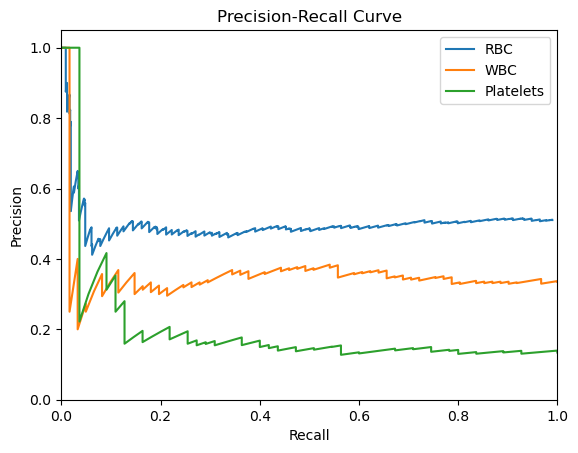

In [32]:
for i in range(len(cell_types)):
    # Create a mask to filter the results for the current class
    
    # Plot the precision-recall curve for the current class
    plt.plot(recall[cell_types[i]], precision[cell_types[i]], label=cell_types[i])

# Set the plot title and axis labels
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

Let's check if we can improve results by running different values of thresholds

In [33]:
thresh_range_p=np.arange(0.4, 0.65, 0.05)
thresh_range_w=np.arange(0.6, 0.85, 0.05)
thresh_range_r=np.arange(0.5, 0.75, 0.05)
nms_thresh_range=np.arange(0.4, 0.8, 0.05)
mAP_list=[]
start_t=time.time()
for w in thresh_range_w:
    for r in thresh_range_r:
        for p in thresh_range_p:
            for nms in nms_thresh_range:
                
                thresh_by_type_d['Platelets']=p
                thresh_by_type_d['RBC']=r
                thresh_by_type_d['WBC']=w
                res_nms3=filtered_predictions(predictions, img_n_r, thresh_by_type_d, nms_iou_threshold=nms)
                precision, recall, average_precision, mAP=calculate_mAP(res_nms3, test_df)
                mAP_list.append({'mAP':mAP, 'Platelets':p, 'RBC':r, 'WBC':w, 'NMS':nms, 'precision':precision, 'recall':recall, 'ap':average_precision})
        
end=time.time()-start_t

In [34]:
max_mAP = max(mAP_list, key=lambda x: x['mAP'])['mAP']
best_results = [x for x in mAP_list if x['mAP'] == max_mAP]
for i in range(len(best_results)):
    result = best_results[i]
    print(f"mAP: {result['mAP']:.4f} | NMS: {result['NMS']:.2f} | Platelets: {result['Platelets']:.2f} | RBC: {result['RBC']:.2f} | WBC: {result['WBC']:.2f}| AP: RBC={result['ap']['RBC']:.2f}, WBC={result['ap']['WBC']:.2f}, Platelets={result['ap']['Platelets']:.2f}")

mAP: 0.8403 | NMS: 0.45 | Platelets: 0.55 | RBC: 0.70 | WBC: 0.75| AP: RBC=0.75, WBC=1.00, Platelets=0.78
mAP: 0.8403 | NMS: 0.45 | Platelets: 0.55 | RBC: 0.70 | WBC: 0.80| AP: RBC=0.75, WBC=1.00, Platelets=0.78


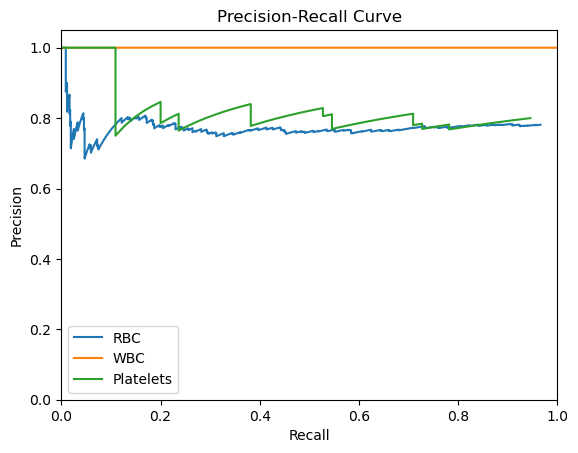

In [35]:
recall=result['recall']
precision=result['precision']
for i in range(len(cell_types)):
    # Create a mask to filter the results for the current class
    
    # Plot the precision-recall curve for the current class
    plt.plot(recall[cell_types[i]], precision[cell_types[i]], label=cell_types[i])

# Set the plot title and axis labels
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [36]:
thresh_by_type_d={'Platelets': 0.55, 'RBC': 0.7, 'WBC': 0.8}
res_final=filtered_predictions(predictions, img_n_r, thresh_by_type_d, nms_iou_threshold=0.45)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


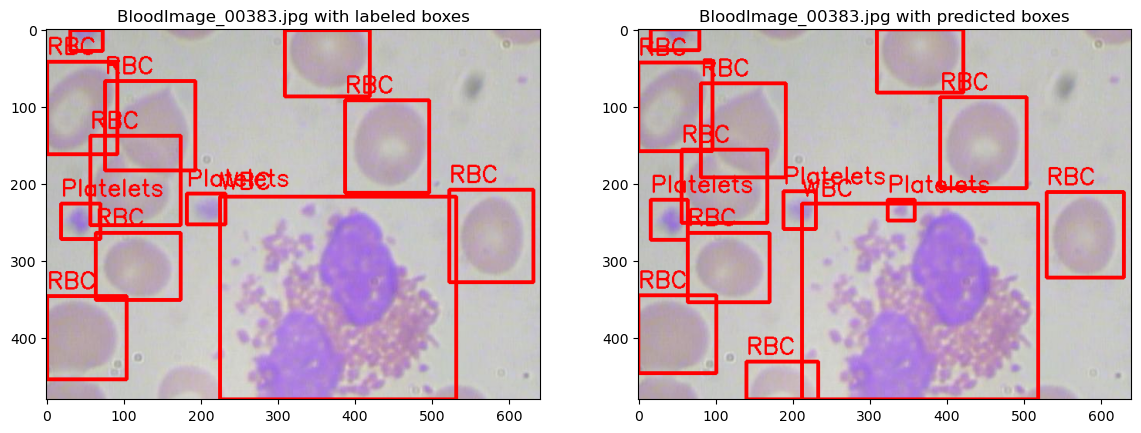

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


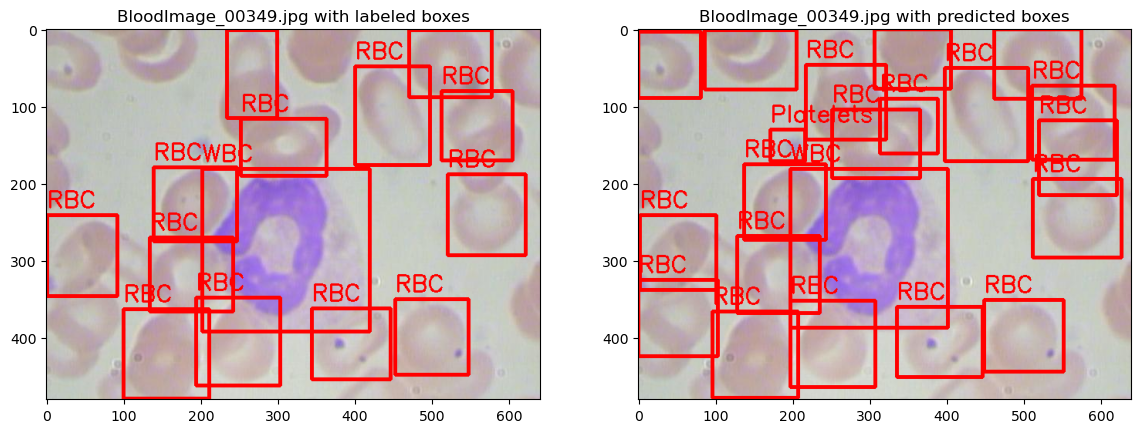

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


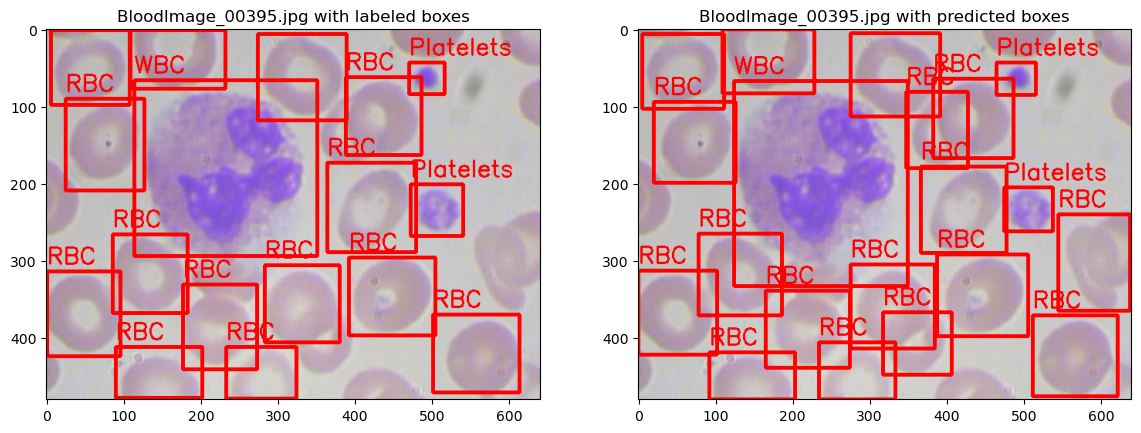

In [37]:
compare_img(test_df,res_final, testing_images[0], "BloodImage_00383.jpg")
compare_img(test_df,res_final, testing_images[0], "BloodImage_00349.jpg")
compare_img(test_df,res_final, testing_images[0], "BloodImage_00395.jpg")

## Model with freezed backbone part

In [38]:
### Create / load model

#Faster - RCNN Model - pretrained on COCO
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model2.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model2.load_state_dict(torch.load('model_backbone_freeze.pt'))
model2.to(device)

/Users/klynete/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/klynete/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [39]:
model2.eval()
img_n_r2=[]
predictions2=[]
with torch.no_grad():
    for images, img_n in test_data_loader:
        images = list(image.to(device) for image in images)
        output = model2(images)
        predictions2=predictions2+output
        img_n_r2=img_n_r2+list(img_n)

In [40]:
thresh_by_type_d={'Platelets': 0, 'RBC': 0, 'WBC': 0}
res_all2=filtered_predictions(predictions2, img_n_r2, thresh_by_type_d, nms_iou_threshold=None)

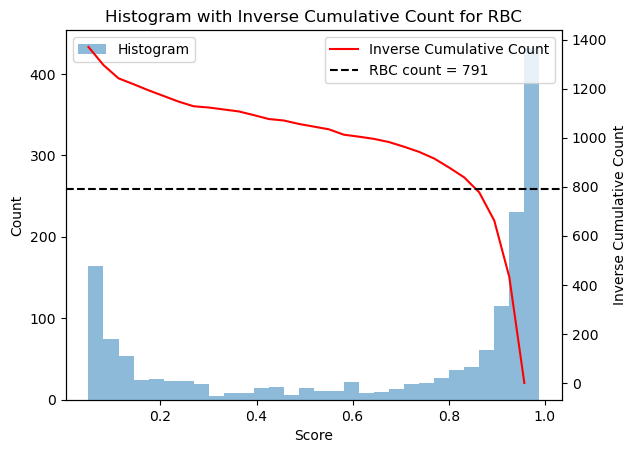

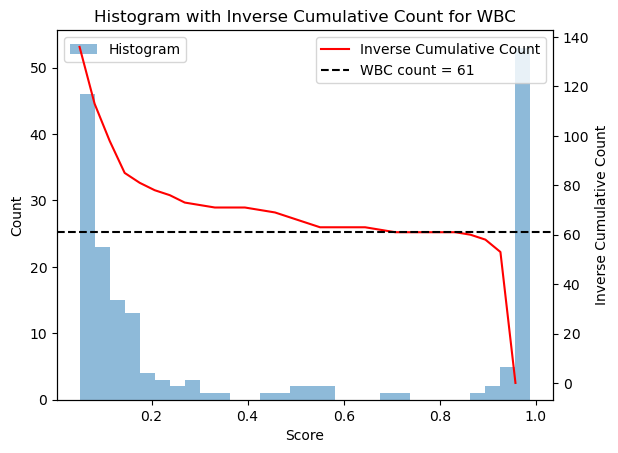

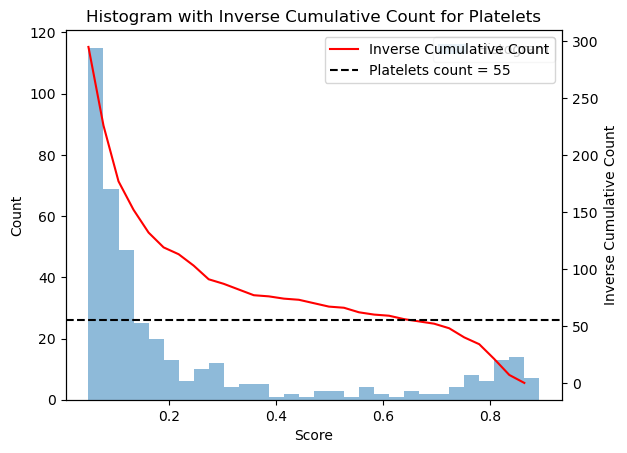

In [41]:
plot_by_cell_type(res_all,'RBC')
plot_by_cell_type(res_all,'WBC')
plot_by_cell_type(res_all,'Platelets')

In [42]:
thresh_range_p=np.arange(0.4, 0.65, 0.05)
thresh_range_w=np.arange(0.6, 0.85, 0.05)
thresh_range_r=np.arange(0.5, 0.75, 0.05)
nms_thresh_range=np.arange(0.4, 0.8, 0.05)
mAP_list2=[]
start_t=time.time()
for w in thresh_range_w:
    for r in thresh_range_r:
        for p in thresh_range_p:
            for nms in nms_thresh_range:
                thresh_by_type_d['Platelets']=p
                thresh_by_type_d['RBC']=r
                thresh_by_type_d['WBC']=w
                res_nms3=filtered_predictions(predictions2, img_n_r2, thresh_by_type_d, nms_iou_threshold=nms)
                precision, recall, average_precision, mAP=calculate_mAP(res_nms3, test_df)
                mAP_list2.append({'mAP':mAP, 'Platelets':p, 'RBC':r, 'WBC':w, 'NMS':nms, 'precision':precision, 'recall':recall, 'ap':average_precision})
        
end=time.time()-start_t

In [43]:
max_mAP2 = max(mAP_list2, key=lambda x: x['mAP'])['mAP']
best_results = [x for x in mAP_list2 if x['mAP'] == max_mAP2]
for i in range(len(best_results)):
    result = best_results[i]
    print(f"mAP: {result['mAP']:.4f} | NMS: {result['NMS']:.2f} | Platelets: {result['Platelets']:.2f} | RBC: {result['RBC']:.2f} | WBC: {result['WBC']:.2f}| AP: RBC={result['ap']['RBC']:.2f}, WBC={result['ap']['WBC']:.2f}, Platelets={result['ap']['Platelets']:.2f}")

mAP: 0.6973 | NMS: 0.45 | Platelets: 0.55 | RBC: 0.70 | WBC: 0.75| AP: RBC=0.73, WBC=0.81, Platelets=0.55


In [44]:
thresh_by_type_d={'Platelets': 0.55, 'RBC': 0.7, 'WBC': 0.75}
res_final2=filtered_predictions(predictions2, img_n_r2, thresh_by_type_d, nms_iou_threshold=0.45)

In [45]:
precision, recall, average_precision, mAP=calculate_mAP(res_final2, test_df)
average_precision

{'RBC': 0.7332239842793586,
 'WBC': 0.8069575369941914,
 'Platelets': 0.5516729251391029}

In [46]:
mAP

0.6972848154708844

Let's plot resulting image with predicted and filtered boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


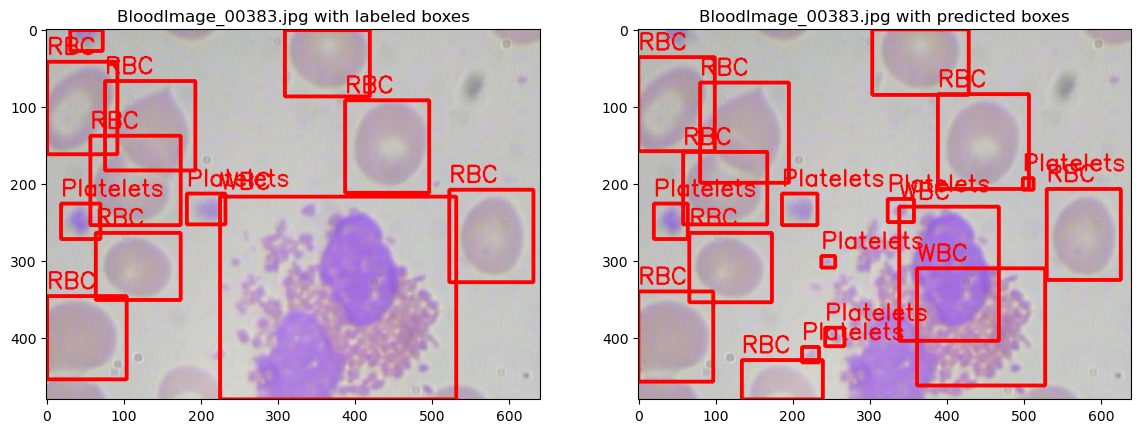

In [47]:
compare_img(test_df, res_final2, testing_images[0], "BloodImage_00383.jpg")

# Summary

1. Visualy it is clear that this model performs less precise detecting 'WBC' and 'Platelets' cells

2. Without retraining RPN backbone part of Faster R-CNN model results are much lower than in first case where the total model parameters were fine tuned for our dataset images.

Results for fully retrained model: **mAP= 0.84**

Average Precision by cell type:

    - 'RBC': 0.75
    - 'WBC': 1.0
    - 'Platelets': 0.78
 

Results for partially retrained model (RPN backbone layers were frozen): **mAP= 0.7**

Average Precision by cell type:

    - 'RBC': 0.73
    - 'WBC': 0.81
    - 'Platelets': 0.55
 

3. Possible improvements:
    - As we can see, not all images in the training dataset have all the required labels for 'RBC' and 'Platelets'. There is a possibility that the model's performance can be improved if we correct the labeling.
    - Increase number of epochs the model was trained. Additional GPU can be used from external services.
    - Data augmentation: Augmenting the training data with more diverse and larger data can help the model generalize better to different scenarios. Techniques such as random flipping, scaling, rotation, and adding noise can be applied to augment the training data.
    - Fine-tuning pre-trained models: By fine-tuning the RPN backbone part of the model on medical image datasets, the model can learn more robust features and improve its accuracy.
    - Predictions filtration: Depending on the requirements and task, we can optimize not only mAP but also separately optimize AP for interested classes. In our case, the model is precise for 'WBC' but less precise for 'Platelets'. Here, we can use other methods of thresholding prediction results. For example, we can use K-nearest neighbor (KNN) and a small threshold of intersection over union (IOU) in each platelet case to avoid their double counting in some cases.